<a href="https://colab.research.google.com/github/jimitogni/dissertacao/blob/master/covid19_multiple_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Head

In [2]:
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, VGG16, InceptionV3
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

%matplotlib inline

Using TensorFlow backend.


In [0]:
#criando o nosso top layer
def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu')(top_model)
  top_model = Dense(1024, activation='relu')(top_model)
  top_model = Dense(512, activation='relu')(top_model)
  top_model = Dropout(0,2)(top_model)
  top_model = Dense(num_classes, activation='softmax')(top_model)

  return top_model

#Datasets

In [2]:
%%shell

export KAGGLE_USERNAME=jimitogni
export KAGGLE_KEY=aea778a52ae308a26e4ad5dad779ada9

kaggle datasets download paultimothymooney/chest-xray-pneumonia
unzip '/content/drive/My Drive/UNICAMP/databases/covid19/chest-xray-pneumonia.zip' -d '/content/drive/My Drive/UNICAMP/databases/covid19/'

cd '/content/drive/My Drive/UNICAMP/databases/covid19/'
git clone https://github.com/ieee8023/covid-chestxray-dataset.git

100% 2.29G/2.29G [00:29<00:00, 31.1MB/s]
100% 2.29G/2.29G [00:29<00:00, 83.1MB/s]
'chest-xray-pneumonia.zip' -> '/content/drive/My Drive/UNICAMP/databases/covid19/chest-xray-pneumonia.zip'
cp: '/content/drive/My Drive/UNICAMP/databases/covid19/chest-xray-pneumonia.zip': can make relative symbolic links only in current directory
unzip:  cannot find or open /content/drive/My Drive/UNICAMP/databases/covid19/chest-xray-pneumonia.zip, /content/drive/My Drive/UNICAMP/databases/covid19/chest-xray-pneumonia.zip.zip or /content/drive/My Drive/UNICAMP/databases/covid19/chest-xray-pneumonia.zip.ZIP.
Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 1616, done.
remote: Total 1616 (delta 0), reused 0 (delta 0), pack-reused 1616
Receiving objects: 100% (1616/1616), 219.51 MiB | 14.64 MiB/s, done.
Resolving deltas: 100% (774/774), done.
Checking out files: 100% (350/350), done.


In [6]:
!unzip '/content/drive/My Drive/UNICAMP/databases/covid19/chest-xray-pneumonia.zip' -d '/content/drive/My Drive/UNICAMP/databases/covid19/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/My Drive/UNICAMP/databases/covid19/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: /content/drive/My Drive/UNICAMP/databases/covid19/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: /content/drive/My Drive/UNICAMP/databases/covid19/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: /content/drive/My Drive/UNICAMP/databases/covid19/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: /content/drive/My Drive/UNICAMP/databases/covid19/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: /content/drive/My Drive/UNICAMP/databases/covid19/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: /content/drive/My Drive/UNICAMP/databases/covid19/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: /content/drive/My Drive/UNICAMP/databases/covid19/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: /content/drive/My Drive/UNICAMP/databases/covid19/chest_xray

In [0]:
# Load Kaggle Pneumonia Dataset
def get_dataset(path, label):
  return [[path+x, label] for x in os.listdir(path) if not x.startswith('.')]

In [0]:
def split_dataset():
  #path_drive = '/content/drive/My Drive/UNICAMP/databases/covid19/'
  root = '/content/drive/My Drive/UNICAMP/databases/covid19/chest_xray/train/'
  normal_xray = get_dataset(root+'NORMAL/', 'normal')
  pneumonia_xray = get_dataset(root+'PNEUMONIA/', 'pneumonia')
  #print(len(normal_xray), normal_xray[0:5])
  #print(len(pneumonia_xray), pneumonia_xray[0:5])

  # Load Covid-19 Dataset
  metadata_path='/content/drive/My Drive/UNICAMP/databases/covid19/covid-chestxray-dataset/metadata.csv'
  srcpath = '/content/drive/My Drive/UNICAMP/databases/covid19/covid-chestxray-dataset/images/'
  df=pd.read_csv(metadata_path)
  covid_patients=df['finding']=='COVID-19'
  PA=df['view']=='PA'
  PA_covid=df[covid_patients & PA]
  covid_xray = [[srcpath + files, 'covid'] for files in PA_covid['filename']]
  #print(len(covid_xray), covid_xray[0:5])

  random.shuffle(normal_xray)
  random.shuffle(pneumonia_xray)
  random.shuffle(covid_xray)

  # gerando dados balanceados e randomizados
  print("min_size = {}".format(min(len(normal_xray), len(pneumonia_xray), len(covid_xray))-1))
  min_size = min(len(normal_xray), len(pneumonia_xray), len(covid_xray))-1
  dataset = normal_xray[0:min_size] + covid_xray[0:min_size] + pneumonia_xray[0:min_size]
  random.shuffle(dataset)

  #print(len(dataset), dataset[0:5])

  # carregando os dados para um df pandas
  df = pd.DataFrame(dataset, columns=['X', 'y']).sample(frac=1)
  #print(df)

  X = df['X']
  y = df['y']

  classes= y.unique()
  print("Classes: {}".format(classes))

  # Split em train, val, e test
  from sklearn.model_selection import train_test_split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) #pega 10% do treino e separa para teste
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1) #pega 10% do treino e separa para teste

  print("-----"*10)
  print("Total de imagens= {}, \nDados para: treino= {}, \nValidação= {} \nTeste= {} ".format(len(df), len(X_train), len(X_val), len(X_test)))
  print("-----"*10)
  print("Total Y= {}, \nDados para: Treino= {}, \nValidação= {} \nTeste= {} ".format(len(df), len(y_train), len(y_val), len(y_test)))

  #!rm -rf dataset/ #remove a pasta se ela ja existir

  #cria uma nova pasta com as duas bases de dados agrupadas
  for dtype, dinputs, doutputs in [['train', X_train, y_train], ['val', X_val, y_val], ['test', X_test, y_test]]:
    for _X, _y in zip(dinputs, doutputs):
      path = '/content/drive/My Drive/UNICAMP/databases/covid19/dataset_final/'+dtype+'/'+_y
      os.makedirs(path, exist_ok=True)
      print(_X, path)
      shutil.copy(_X, path)

  #!tar -czf dataset.tar.gz dataset/ #guarda toda a base obtida em um arquivo zip


In [21]:
split_dataset()

min_size = 141
Classes: ['pneumonia' 'normal' 'covid']
--------------------------------------------------
Total de imagens= 423, 
Dados para: treino= 270, 
Validação= 68 
Teste= 85 
--------------------------------------------------
Total Y= 423, 
Dados para: Treino= 270, 
Validação= 68 
Teste= 85 
/content/drive/My Drive/UNICAMP/databases/covid19/covid-chestxray-dataset/images/covid-19-pneumonia-34.png /content/drive/My Drive/UNICAMP/databases/covid19/dataset_final/train/covid
/content/drive/My Drive/UNICAMP/databases/covid19/chest_xray/train/PNEUMONIA/person370_bacteria_1688.jpeg /content/drive/My Drive/UNICAMP/databases/covid19/dataset_final/train/pneumonia
/content/drive/My Drive/UNICAMP/databases/covid19/covid-chestxray-dataset/images/radiol.2020200490.fig3.jpeg /content/drive/My Drive/UNICAMP/databases/covid19/dataset_final/train/covid
/content/drive/My Drive/UNICAMP/databases/covid19/covid-chestxray-dataset/images/80446565-E090-4187-A031-9D3CEAA586C8.jpeg /content/drive/My Drive

In [22]:
# Path to data
data_dir = '/content/drive/My Drive/UNICAMP/databases/covid19/dataset_final/'
train_dir = data_dir+'train/'
test_dir = data_dir+'test/'
val_dir = data_dir+'val/'

# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir + 'normal/'
pneumonia_cases_dir = train_dir + 'pneumonia/'
covid_cases_dir = train_dir + 'covid/'

print("Datasets:",os.listdir(data_dir))
print("Train:\t", os.listdir(train_dir))
print("Test:\t", os.listdir(test_dir))

Datasets: ['train', 'val', 'test']
Train:	 ['covid', 'pneumonia', 'normal']
Test:	 ['normal', 'pneumonia', 'covid']


#Visualizando algumas amostras dos datasets

In [0]:
### VERIFICAR SE AS CLASSES ESTÃO CORRETAS

# Get the list of all the images
normal_cases = glob(normal_cases_dir+'/*.jpeg')
pneumonia_cases = glob(pneumonia_cases_dir+'/*.jpeg')
covid_cases = glob(covid_cases_dir+'/*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Go through all the covid cases. The label for these cases will be 2
for img in covid_cases:
    train_data.append((img, 2))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()
covid_samples = (train_data[train_data['label']==2]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples + covid_samples
del pneumonia_samples, normal_samples, covid_samples

# Plot the data 
f, ax = plt.subplots(3,5, figsize=(30,15))
for i in range(15):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    elif i>=5 and i<10:
        ax[i//5, i%5].set_title("Normal")
    else:
        ax[i//5, i%5].set_title("Covid")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

#Modelos

87916544/87910968 [==============================] - 3s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:680: RuntimeWarning: ModelCheckpoint mode <built-in function min> is unknown, fallback to auto mode.
  RuntimeWarning)


Epoch 1/100
8/8 [==============================] - 44s 5s/step - loss: 1.3840 - accuracy: 0.3613 - val_loss: 1.0249 - val_accuracy: 0.3594

Epoch 00001: val_loss improved from inf to 1.02491, saving model to InceptionV3.h5
Epoch 2/100
8/8 [==============================] - 33s 4s/step - loss: 1.0808 - accuracy: 0.3908 - val_loss: 0.9402 - val_accuracy: 0.4444

Epoch 00002: val_loss improved from 1.02491 to 0.94017, saving model to InceptionV3.h5
Epoch 3/100
8/8 [==============================] - 34s 4s/step - loss: 0.8173 - accuracy: 0.6484 - val_loss: 3.5206 - val_accuracy: 0.3889

Epoch 00003: val_loss did not improve from 0.94017
Epoch 4/100
8/8 [==============================] - 37s 5s/step - loss: 0.8923 - accuracy: 0.5924 - val_loss: 1.3983 - val_accuracy: 0.4844

Epoch 00004: val_loss did not improve from 0.94017
Epoch 5/100
8/8 [==============================] - 37s 5s/step - loss: 0.7456 - accuracy: 0.6891 - val_loss: 1.0282 - val_accuracy: 0.3611

Epoch 00005: val_loss did no

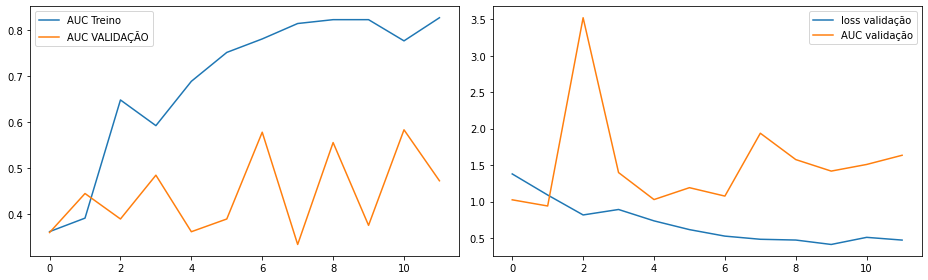



Com os valores:
batch size: 32 - Epocas: 100


In [4]:
#InceptionV3
img_rows, img_cols = 224, 224

InceptionV3 = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3)) #largura, altura, 3=RGB colorido

for layer in InceptionV3.layers:
  layer.trainable=False

num_classes = 3

FC = addTopModel(InceptionV3, num_classes) #MobileNet = bottom_model
model = Model(input=InceptionV3.input, output=FC) #bottom layers, top layer

model.summary()

train_data_dir = '/content/drive/My Drive/UNICAMP/databases/covid19/dataset_final/train'
validation_data_dir = '/content/drive/My Drive/UNICAMP/databases/covid19/dataset_final/val'

#data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

#nao faz data aug
validation_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
                                                              target_size=(img_rows, img_cols),
                                                              batch_size=batch_size,
                                                              class_mode='categorical')


checkpoint = ModelCheckpoint('InceptionV3.h5',
                             monitor='val_loss',
                             mode=min,
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=5,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.0001)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

nb_train_samples = 270
nb_validation_samples = 68

epochs = 100
batch_size = 32

history = model.fit_generator(train_generator,
                              steps_per_epoch=nb_train_samples//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=nb_validation_samples//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

print()
print("Com os valores:")
print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##ResNet50v2

##Inceptionv3

##InceptionResNetv2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if sys.path[0] == '':


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 111, 111, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 111, 111, 32) 0           batch_normalization_95[0][0]     
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:680: RuntimeWarning: ModelCheckpoint mode <built-in function min> is unknown, fallback to auto mode.
  RuntimeWarning)


Epoch 1/100
8/8 [==============================] - 69s 9s/step - loss: 1.4073 - accuracy: 0.3109 - val_loss: 1.1788 - val_accuracy: 0.6250

Epoch 00001: val_loss improved from inf to 1.17879, saving model to InceptionResNetV2.h5
Epoch 2/100
8/8 [==============================] - 58s 7s/step - loss: 1.0669 - accuracy: 0.4034 - val_loss: 1.1183 - val_accuracy: 0.3889

Epoch 00002: val_loss improved from 1.17879 to 1.11834, saving model to InceptionResNetV2.h5
Epoch 3/100
8/8 [==============================] - 57s 7s/step - loss: 0.9411 - accuracy: 0.5840 - val_loss: 1.3773 - val_accuracy: 0.4167

Epoch 00003: val_loss did not improve from 1.11834
Epoch 4/100
8/8 [==============================] - 63s 8s/step - loss: 0.8926 - accuracy: 0.5756 - val_loss: 0.5664 - val_accuracy: 0.5781

Epoch 00004: val_loss improved from 1.11834 to 0.56641, saving model to InceptionResNetV2.h5
Epoch 5/100
8/8 [==============================] - 58s 7s/step - loss: 0.7507 - accuracy: 0.7059 - val_loss: 0.419

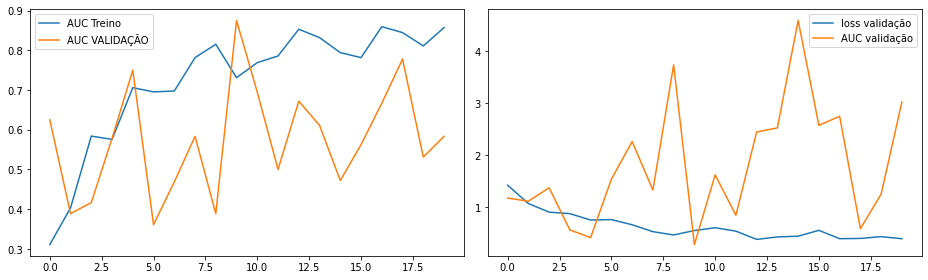



Com os valores:
batch size: 32 - Epocas: 100


In [5]:
#InceptionResNetV2

img_rows, img_cols = 224, 224

InceptionResNetV2 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) #largura, altura, 3=RGB colorido

for layer in InceptionResNetV2.layers:
  layer.trainable=False

num_classes = 3

FC = addTopModel(InceptionResNetV2, num_classes) #MobileNet = bottom_model
model = Model(input=InceptionResNetV2.input, output=FC) #bottom layers, top layer

model.summary()

train_data_dir = '/content/drive/My Drive/UNICAMP/databases/covid19/dataset_final/train'
validation_data_dir = '/content/drive/My Drive/UNICAMP/databases/covid19/dataset_final/val'

#data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

#nao faz data aug
validation_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
                                                              target_size=(img_rows, img_cols),
                                                              batch_size=batch_size,
                                                              class_mode='categorical')

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('macacos_modelo.h5',
                             monitor='val_loss',
                             mode=min,
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=5,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.0001)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('InceptionResNetV2.h5',
                             monitor='val_loss',
                             mode=min,
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=5,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.0001)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

nb_train_samples = 270
nb_validation_samples = 68

epochs = 100
batch_size = 32

history = model.fit_generator(train_generator,
                              steps_per_epoch=nb_train_samples//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=nb_validation_samples//batch_size)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import os

print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

print()
print("Com os valores:")
print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##DenseNet201

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:680: RuntimeWarning: ModelCheckpoint mode <built-in function min> is unknown, fallback to auto mode.
  RuntimeWarning)


Epoch 1/100
8/8 [==============================] - 92s 11s/step - loss: 1.4303 - accuracy: 0.3992 - val_loss: 0.9935 - val_accuracy: 0.5625

Epoch 00001: val_loss improved from inf to 0.99351, saving model to macacos_modelo.h5
Epoch 2/100
8/8 [==============================] - 75s 9s/step - loss: 0.7908 - accuracy: 0.6639 - val_loss: 0.7361 - val_accuracy: 0.6111

Epoch 00002: val_loss improved from 0.99351 to 0.73614, saving model to macacos_modelo.h5
Epoch 3/100
8/8 [==============================] - 74s 9s/step - loss: 0.5728 - accuracy: 0.7311 - val_loss: 0.9573 - val_accuracy: 0.5556

Epoch 00003: val_loss did not improve from 0.73614
Epoch 4/100
8/8 [==============================] - 83s 10s/step - loss: 0.5226 - accuracy: 0.7941 - val_loss: 0.6523 - val_accuracy: 0.7656

Epoch 00004: val_loss improved from 0.73614 to 0.65227, saving model to macacos_modelo.h5
Epoch 5/100
8/8 [==============================] - 76s 9s/step - loss: 0.3379 - accuracy: 0.8739 - val_loss: 1.1841 - val

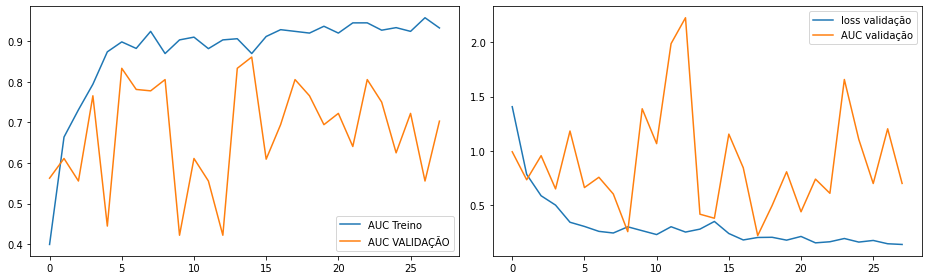



Com os valores:
batch size: 32 - Epocas: 100


In [6]:
#DenseNet201
img_rows, img_cols = 224, 224

DenseNet201 = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet201.layers:
  layer.trainable=False

num_classes = 3

FC = addTopModel(DenseNet201, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet201.input, output=FC) #bottom layers, top layer

model.summary()

train_data_dir = '/content/drive/My Drive/UNICAMP/databases/covid19/dataset_final/train'
validation_data_dir = '/content/drive/My Drive/UNICAMP/databases/covid19/dataset_final/val'

#data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

#nao faz data aug
validation_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
                                                              target_size=(img_rows, img_cols),
                                                              batch_size=batch_size,
                                                              class_mode='categorical')

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('DenseNet201.h5',
                             monitor='val_loss',
                             mode=min,
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=5,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.0001)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('macacos_modelo.h5',
                             monitor='val_loss',
                             mode=min,
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=5,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.0001)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

nb_train_samples = 270
nb_validation_samples = 68

epochs = 100
batch_size = 32

history = model.fit_generator(train_generator,
                              steps_per_epoch=nb_train_samples//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=nb_validation_samples//batch_size)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import os

print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

print()
print("Com os valores:")
print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##VGG19

##MobileNet

##NASnet

##Xcepiton

#Resultados

In [0]:
print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

print()
print("Com os valores:")
print("batch size: {} - Epocas: {}".format(batch_size, epochs))